# Exploratory Data Analysis (EDA)

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

## 1. Merge The Sources

In [3]:
path1 = os.path.abspath('../data/saved_data/clean_citibike_trips.parquet')
path2 = os.path.abspath('../data/saved_data/clean_citibike_stations.parquet')

In [4]:
df1 = pd.read_parquet(path1)
df2 = pd.read_parquet(path2)

In [5]:
df1 = df1[2024 < df1['started_at'].dt.year]

In [6]:
first_merge = df1.merge(
    right=df2[['borough', 'postcode']].add_prefix('start_'),
    how='left',
    left_on='start_station_id',
    right_index=True
)

df3 = first_merge.merge(
    right=df2[['borough', 'postcode']].add_prefix('end_'),
    how='left',
    left_on='end_station_id',
    right_index=True
)

In [7]:
if df3.shape[0] == df1.shape[0]:
    print('Dataframes successfully merged!')

Dataframes successfully merged!


In [8]:
df3.head()

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration,trip_distance,start_borough,start_postcode,end_borough,end_postcode
ride_id,,,,,,,,,,,,,,,,,,
56BD148A05E26915,Electric,2025-01-01 22:19:06.324,2025-01-01 22:23:32.899,W 36 St & 7 Ave,"6,483.06",W 24 St & 7 Ave,"6,257.03",40.75,-73.99,40.74,-74.00,Member,266,0.59,Manhattan,10018,Manhattan,10011
700CCCDF00C08077,Electric,2025-01-09 15:20:43.991,2025-01-09 15:26:19.137,Broadway & E 19 St,"5,980.11",W 24 St & 7 Ave,"6,257.03",40.74,-73.99,40.74,-74.00,Member,335,0.53,Manhattan,10003,Manhattan,10011
B1A3FAFA5FE651CE,Electric,2025-01-01 12:54:26.571,2025-01-01 13:03:03.565,Jackson Ave & 46 Rd,"6,203.02",Crescent St & Broadway,"6,827.11",40.75,-73.95,40.76,-73.93,Member,516,1.59,Queens,11101,Queens,11106
9CB0F28054BA5EBC,Electric,2025-01-14 13:43:59.151,2025-01-14 13:49:04.543,Broadway & E 19 St,"5,980.11",W 24 St & 7 Ave,"6,257.03",40.74,-73.99,40.74,-74.00,Member,305,0.53,Manhattan,10003,Manhattan,10011
A1B8FDD4FAF0C2B2,Electric,2025-01-13 07:20:37.176,2025-01-13 07:29:18.015,Willis Ave & E 143 St,"7,798.02",1 Ave & E 110 St,"7,522.02",40.81,-73.92,40.79,-73.94,Member,520,1.67,The Bronx,10454,Manhattan,10029


## 2. Analyze Trips

### 2a. Display statistics on the time and distance traveled by each borough.

- **Manhattan** and **Brooklyn** have the most frequent trips with the highest average trip time/distance
- Bike trips average around **10 minutes** and **1 mile**
- Dispersion of time and duration across the 5 boroughs is almost close (**Brooklyn** has higher trip duration based on the IQR)

In [9]:
df3.groupby(
    'start_borough'
)[
    [
        'trip_duration',
        'trip_distance'
    ]
].agg(
    ['mean', 'median', 'std', 'count']
)

trip_duration                         trip_distance              \
                       mean median    std     count          mean median  std   
start_borough                                                                   
Brooklyn             693.76 515.00 592.37   5441472          1.27   0.95 1.05   
Manhattan            694.20 509.00 632.26  12657829          1.21   0.91 1.03   
Queens               636.50 433.00 605.64   1365206          1.17   0.78 1.11   
The Bronx            659.93 449.00 692.12    572830          1.12   0.80 1.14   

                         
                  count  
start_borough            
Brooklyn        5441472  
Manhattan      12657829  
Queens          1365206  
The Bronx        572830

In [10]:
def calculate_iqr(data):
    q1 = np.quantile(data, 0.25)
    q2 = np.quantile(data, 0.75)
    return q2 - q1

df3.groupby(
    'start_borough'
)[
    [
        'trip_duration',
        'trip_distance'
    ]
].agg(
    ['median', calculate_iqr]
)

trip_duration               trip_distance              
                     median calculate_iqr        median calculate_iqr
start_borough                                                        
Brooklyn             515.00        612.00          0.95          1.18
Manhattan            509.00        552.00          0.91          1.01
Queens               433.00        552.00          0.78          1.05
The Bronx            449.00        549.00          0.80          1.06

### 2b. Create a histogram for the duration/time of trips by bike type.

- Both distributions are **right-skewed**
- Shaped like an **exponential** distribution
- Riders are more often riding electric bikes

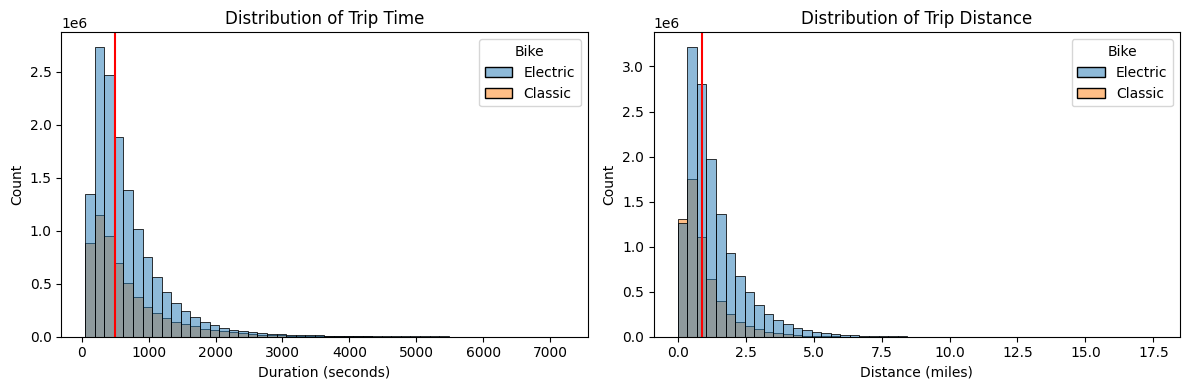

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

median_duration, median_distance = df3['trip_duration'].median(), df3['trip_distance'].median()

sns.histplot(
    data=df3,
    x='trip_duration',
    hue='rideable_type',
    bins=50,
    ax=axs[0],
)

axs[0].axvline(median_duration, color='red')
axs[0].set_title('Distribution of Trip Time')
axs[0].set_xlabel('Duration (seconds)')
axs[0].get_legend().set_title('Bike')

sns.histplot(
    data=df3,
    x='trip_distance',
    hue='rideable_type',
    bins=50,
    ax=axs[1]
)

axs[1].axvline(median_distance, color='red')
axs[1].set_title('Distribution of Trip Distance')
axs[1].set_xlabel('Distance (miles)')
axs[1].get_legend().set_title('Bike')

plt.tight_layout()
plt.show()

### 2c. Create a matrix for total riders by month and weekday

- **January** and **February** were the lowest performing months
- Bike riding picks up after **March**

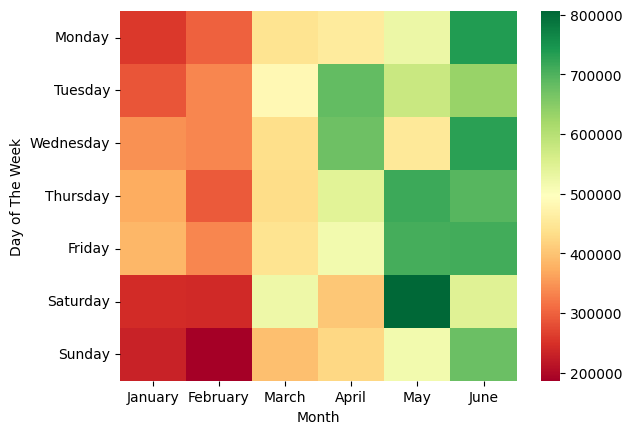

In [12]:
df3['day_name'] = df3['started_at'].dt.day_name()
df3['month'] = df3['started_at'].dt.month_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

matrix_1 = df3.pivot_table(
    index='day_name',
    columns='month',
    aggfunc='size',
    fill_value=0
    )[
        ['January', 'February', 'March', 'April', 'May', 'June']
    ]

matrix_1 = matrix_1.reindex(day_order)

sns.heatmap(
    matrix_1,
    cmap='RdYlGn'
)

plt.xlabel('Month')
plt.ylabel('Day of The Week')
plt.show()

### 2d. Create a matrix for total riders by hour and weekdays

- There are two peaks for the total number of riders on weekdays (Monday-Friday), **6-9am**, and **5-7pm**
- During rush hours, the bikes are being used to travel to work or home

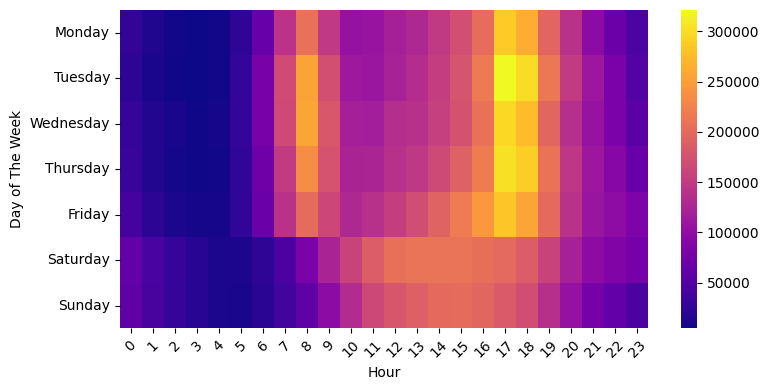

In [13]:
df3['start_hour'] = df3['started_at'].dt.hour 

matrix_2 = df3.pivot_table(index='day_name', columns='start_hour', aggfunc='size', fill_value=0)
matrix_2 = matrix_2.reindex(day_order)

plt.figure(figsize=(8, 4))

sns.heatmap(
    matrix_2,
    cmap='plasma'
)

plt.xlabel('Hour')
plt.ylabel('Day of The Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2e. Popular starting bike stations by borough

- The starting locations are at hot spots with **restaurants**, **stadiums**, **museums**, **parks**, **bridges**, **piers**, and more

In [14]:
df3.groupby(
    [
        'start_borough',
    ]
)['start_station_name'].apply(
    lambda group:
    group.value_counts().head()
).rename_axis(
    index={
        'start_borough': 'Borough'
    }
    ).to_frame(name='Popular Stations')

Popular Stations
Borough                                                     
Brooklyn  N 7 St & Driggs Ave                          42602
          N 6 St & Bedford Ave                         39106
          Metropolitan Ave & Bedford Ave               38075
          Hanson Pl & Ashland Pl                       37519
          S 2 St & Kent Ave                            37276
Manhattan W 21 St & 6 Ave                              74591
          Pier 61 at Chelsea Piers                     68993
          Lafayette St & E 8 St                        62980
          West St & Chambers St                        61496
          W 31 St & 7 Ave                              61376
Queens    Queens Plaza North & Crescent St             22557
          Vernon Blvd & 50 Ave                         20558
          46 Ave & 5 St                                19540
          Jackson Ave & 49 Ave                         19349
          31 St & Broadway                             19223
The Bronx E 161 St & River Ave                          9308
          Melrose Ave & E 150 St                        8404
          Grand Concourse & E 161 St                    5993
          Plaza Dr & W 170 St                           5679
          Lincoln Ave & E 138 St                        5320

### 2f. Popular end stations by borough

- Similar to the popular start stations, most riders start and end trips at these hot spots

In [15]:
df3.groupby(
    ['start_borough']
)['end_station_name'].apply(
    lambda group:
    group.value_counts().head()
).rename_axis(
    index={
        'start_borough': 'Borough'
    }
).to_frame('Popular End Stations')

Popular End Stations
Borough                                                       
Brooklyn  N 7 St & Driggs Ave                            38491
          Hanson Pl & Ashland Pl                         35827
          N 6 St & Bedford Ave                           34566
          Metropolitan Ave & Bedford Ave                 31676
          S 2 St & Kent Ave                              31171
Manhattan W 21 St & 6 Ave                                72642
          Pier 61 at Chelsea Piers                       67467
          W 31 St & 7 Ave                                59978
          West St & Chambers St                          59794
          Lafayette St & E 8 St                          59764
Queens    31 St & Broadway                               17297
          31 St & Newtown Ave                            15318
          46 Ave & 5 St                                  15267
          Steinway St & Broadway                         14628
          31 St & Ditmars Blvd                           14305
The Bronx Melrose Ave & E 150 St                          7929
          E 161 St & River Ave                            7546
          Plaza Dr & W 170 St                             5146
          Grand Concourse & E 161 St                      4471
          Morris Ave & E 163 St                           4458

### 2g. Top 10 zip codes with the most Citi Bike stations near the area

- **Long Island City** has multiple Citi bike stations, this area allows riders to access the 5 boroughs easily

In [16]:
df3.groupby(
    'start_postcode'
)['start_station_id'].agg(
    'nunique'
).sort_values(ascending=False).rename_axis(
    index={
        'start_postcode': 'Zip Code'
    }
).head(10).to_frame(
    'Number of Stations'
)

,Number of Stations
Zip Code,
11101,73
11233,52
11377,48
11368,44
11385,39
11373,39
11215,38
11211,37
11231,37


## 3. Analyze Users

### 3a. Create a box plot with the relationship of trip duration by boroughs and users

- **Casual** users on average spend more time on bikes than users with a membership 

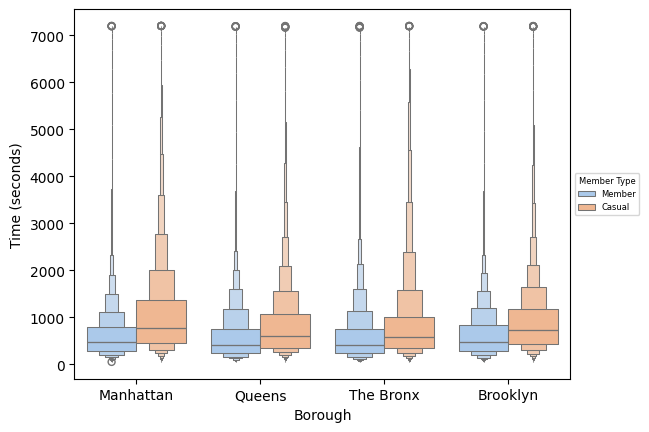

In [17]:
sns.boxenplot(
    data=df3,
    x='start_borough',
    y='trip_duration',
    hue='member_casual',
    palette='pastel'
    )

plt_legend = plt.legend(fontsize=6, loc='center left', bbox_to_anchor=(1, 0.5))
plt_legend.set_title('Member Type', prop={'size': 6})
plt.xlabel('Borough')
plt.ylabel('Time (seconds)')
plt.show()

### 3b. What are the most popular start and end stations by boroughs and users?

- **Casual** users typically return the bike at the same station
- **Member** users are most likely local residents

In [18]:
df3.groupby(
    ['start_borough', 'member_casual']
)[['start_station_name', 'end_station_name']].apply(
    lambda group:
    group.value_counts().head(5)
).rename_axis(
    index={
        'member_casual': 'User',
        'start_borough': 'Borough',
        'start_station_name': 'Starting Station',
        'end_station_name': 'Ending Station'
    }
).to_frame('Count')

Count
Borough   User   Starting Station                  Ending Station                          
Brooklyn  Casual West Drive & Prospect Park West   West Drive & Prospect Park West      827
                 Brooklyn Bridge Park - Pier 2     Brooklyn Bridge Park - Pier 2        726
                 Parkside Ave & Ocean Ave          Parkside Ave & Ocean Ave             715
                 Plaza St East & Flatbush Ave      Plaza St East & Flatbush Ave         598
                 Park Circle & East Dr             Park Circle & East Dr                523
          Member Franklin St & Dupont St           Jackson Ave & 49 Ave                2857
                 N 6 St & Bedford Ave              S 4 St & Wythe Ave                  2249
                                                   S 2 St & Kent Ave                   2109
                 Richardson St & N Henry St        Graham Ave & Conselyea St           2024
                 S 4 St & Wythe Ave                N 6 St & Bedford Ave                1994
Manhattan Casual Central Park S & 6 Ave            Central Park S & 6 Ave              5766
                 7 Ave & Central Park South        7 Ave & Central Park South          5195
                 Roosevelt Island Tramway          Roosevelt Island Tramway            2802
                 Central Park S & Grand Army Plaza Central Park S & Grand Army Plaza   2528
                 5 Ave & E 72 St                   5 Ave & E 72 St                     1728
          Member Norfolk St & Broome St            Henry St & Grand St                 3039
                 Henry St & Grand St               Norfolk St & Broome St              2786
                 W 21 St & 6 Ave                   9 Ave & W 22 St                     2671
                 North Moore St & Greenwich St     Vesey St & Greenwich St             2666
                 E 77 St & 1 Ave                   2 Ave & E 72 St                     2582
Queens    Casual Jackson Ave & 49 Ave              Franklin St & Dupont St              485
                                                   Ash St & Manhattan Ave               278
                 Center Blvd & 51 Ave              Center Blvd & 51 Ave                 278
                 55 Ave & Center Blvd              Vernon Blvd & 50 Ave                 252
                 Astoria Park S & Shore Blvd       Astoria Park S & Shore Blvd          220
          Member 55 Ave & Center Blvd              Vernon Blvd & 50 Ave                2833
                 Vernon Blvd & 50 Ave              55 Ave & Center Blvd                2621
                 Jackson Ave & 49 Ave              Franklin St & Dupont St             2560
                 46 Ave & 5 St                     45 Ave & 21 St                      1794
                                                   Vernon Blvd & 50 Ave                1744
The Bronx Casual Broadway & Van Cortlandt Park S   Broadway & Van Cortlandt Park S      263
                 E 161 St & River Ave              E 161 St & River Ave                 190
                 Crescent Ave & Belmont Ave        E 188 St & Creston Ave               120
                 Ogden Ave & W 165 St              E 161 St & River Ave                 101
                 Brook Ave & E 138 St              Brook Ave & E 138 St                 100
          Member E 161 St & River Ave              E 161 St & River Ave                 541
                 Paul Ave & W 205 St               Jerome Ave & Bedford Park Blvd E     431
                 Goulden Ave & W 205 St            Jerome Ave & Bedford Park Blvd E     387
                 Gerard Ave & E 146 St             Gerard Ave & E 146 St                367
                 Jerome Ave & Bedford Park Blvd E  Paul Ave & W 205 St                  361

### 3c. Number of Citi Bike users by borough and area code

- Hot area codes for users by each borough
    - **The Bronx**: Yankee Stadium
    - **Manhattan**: 59th Street
    - **Queens**: Long Island City
    - **Brooklyn**: Williamsburg Bridge

In [19]:
df3.groupby(
    ['start_borough', 'member_casual']
)['start_postcode'].apply(
    lambda group:
    group.value_counts().head()
).rename_axis(
    index={
        'start_borough': 'Borough',
        'member_casual': 'User'
    }
).to_frame('Top Area Code')

Top Area Code
Borough   User                       
Brooklyn  Casual 11211          87758
                 11249          76423
                 11201          67082
                 11222          62566
                 11215          58034
          Member 11211         439047
                 11222         374745
                 11215         336679
                 11249         336078
                 11201         296937
Manhattan Casual 10019         135754
                 10014         117497
                 10003         104986
                 10002         101697
                 10011          95265
          Member 10003         708918
                 10019         684328
                 10009         659458
                 10011         640900
                 10002         629684
Queens    Casual 11101          50635
                 11385          21588
                 11377          17192
                 11372          13750
                 11373          13682
          Member 11101         309146
                 11377          96227
                 11106          88388
                 11385          80807
                 11103          72589
The Bronx Casual 10451          14815
                 10456          13344
                 10458          10048
                 10468           9573
                 10454           9024
          Member 10456          69480
                 10451          67268
                 10457          39369
                 10452          38059
                 10454          37639